# 日本古典籍字形データセットを利用したDeep Learning実験メモ（2016/11/18）

『日本古典籍字形データセット』（国文研所蔵・CODH加工）
（提供：[人文学オープンデータ共同利用センター](http://codh.rois.ac.jp/)）を利用したDeep Learning実験を行う．

## 教師用データの作成

『日本古典籍字形データセット』の『[料理物語](http://codh.rois.ac.jp/char-shape/book/200021802/)』のデータの一部を使って教師用データを作成する．

In [90]:
import os
import cv2 as cv
import six.moves.cPickle as pickle
import numpy as np

dic={'U+8272':1,'U+3069':2,'U+306B':3,'U+307C':4,'U+9152':5,'U+540C':6,'U+5347':7,'U+304C':8,'U+3067':9,'U+3070':10}

data = []
target = []
IMG_PATH = "./200021802/characters/"
dn=0
tmp = os.listdir(IMG_PATH)
for d in tmp:
   if not d.startswith("U+"):
     continue
   if(not dic.has_key(d)):
     continue
   tmp2 = os.listdir(IMG_PATH+d)
   for f in tmp2:
     image = cv.imread(IMG_PATH+d+"/"+f)
     image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
     image = cv.resize(image, (32, 32))
     image = image/255.0
     data.append(image)
     target.append(dic[d])

data = np.array(data, np.float32)
target = np.array(target, np.int32)
pickle.dump((data,target), open("datasetmono.pkl", 'wb'), -1)

## モデルの作成

In [97]:
%matplotlib inline
from __future__ import division, print_function
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
import six.moves.cPickle as pickle
np.set_printoptions(suppress=True) #小数点表示とする
np.set_printoptions(precision=3) #小数点第三位までとする


In [3]:
dataset,target = pickle.load(open("datasetmono.pkl","rb"))

In [4]:
dataset.shape

(1474, 32, 32)

In [5]:
target.shape

(1474,)

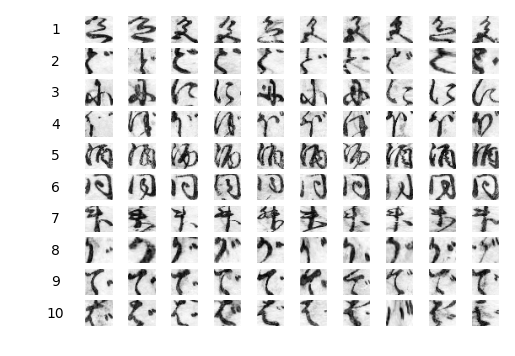

In [6]:
import matplotlib.pyplot as plt

label_images = {label: [] for label in set(target.tolist())}
for x, label in zip(dataset, target):
    label_images[label].append(x)

for j, (label, images) in enumerate(label_images.items()):
    plt.subplot(10, 11, j * 11 + 1)
    plt.text(0.5, 0.5, label, ha='center', va='center')
    plt.axis('off')
    for i, image in enumerate(images):
        if i >= 10:
            continue
        plt.subplot(10, 11, j * 11 +  i + 2)
        plt.imshow(image, cmap='Greys_r')
        plt.axis('off')
plt.show()
    
del label_images

In [91]:
x_dataset = dataset

In [92]:
x_dataset.shape

(1474, 32, 32)

In [93]:
x_dataset[1].shape

(32, 32)

In [94]:
y_target = to_categorical(target)

In [95]:
y_target

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [102]:
model = Sequential()
model.add(Convolution1D(96, 3, border_mode='same', input_shape=x_dataset[1].shape))
model.add(Activation('relu'))
model.add(Convolution1D(32, 2))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Convolution1D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution1D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(11))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 学習

In [111]:
model.fit(x_dataset, y_target, batch_size=128, nb_epoch=200, verbose=1)

Epoch 1/200
1474/1474 [==============================] - 0s - loss: 1.4780 - acc: 0.5699     
Epoch 2/200
1474/1474 [==============================] - 0s - loss: 1.4315 - acc: 0.5746     
Epoch 3/200
1474/1474 [==============================] - 0s - loss: 1.3999 - acc: 0.5821     
Epoch 4/200
1474/1474 [==============================] - 0s - loss: 1.3630 - acc: 0.5902     
Epoch 5/200
1474/1474 [==============================] - 0s - loss: 1.3351 - acc: 0.5970     
Epoch 6/200
1474/1474 [==============================] - 0s - loss: 1.2893 - acc: 0.6072     
Epoch 7/200
1474/1474 [==============================] - 0s - loss: 1.2374 - acc: 0.6147     
Epoch 8/200
1474/1474 [==============================] - 0s - loss: 1.1599 - acc: 0.6336     
Epoch 9/200
1474/1474 [==============================] - 0s - loss: 1.1604 - acc: 0.6398     
Epoch 10/200
1474/1474 [==============================] - 0s - loss: 1.0837 - acc: 0.6567     
Epoch 11/200
1474/1474 [==============================] - 0

モデルの保存

In [112]:
model.save("model20161118b.h5")

## くずし字識別実験

In [113]:
dic={1:u'\u8272',2:u'\u3069',3:u'\u306B',4:u'\u307C',5:u'\u9152',6:u'\u540C',7:u'\u5347',8:u'\u304C',9:u'\u3067',10:u'\u3070'}

### ケース1 OK

1/1 [==============================] - 0s
が


u'\u304c'

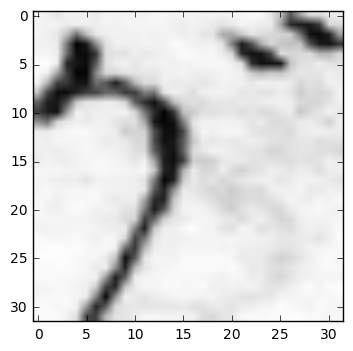

In [142]:
image = cv.imread("u304c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
x.shape
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [143]:
model.predict(x)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

### ケース2 NG

1/1 [==============================] - 0s
に


u'\u306b'

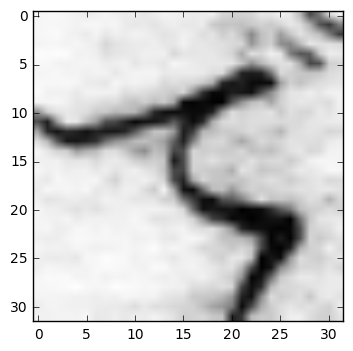

In [124]:
image = cv.imread("u3067_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [125]:
model.predict(x)

array([[ 0.   ,  0.   ,  0.   ,  0.997,  0.   ,  0.   ,  0.   ,  0.003,
         0.   ,  0.   ,  0.   ]], dtype=float32)

### ケース3 NG

1/1 [==============================] - 0s
に


u'\u306b'

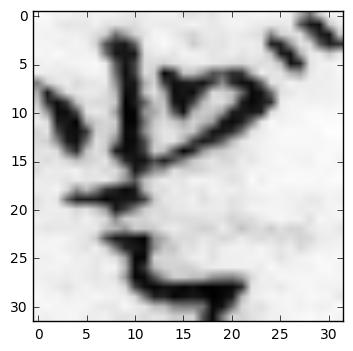

In [126]:
image = cv.imread("u3069_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [127]:
model.predict(x)

array([[ 0.   ,  0.   ,  0.   ,  0.844,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.155,  0.   ]], dtype=float32)

### ケース4 OK

1/1 [==============================] - 0s
に


u'\u306b'

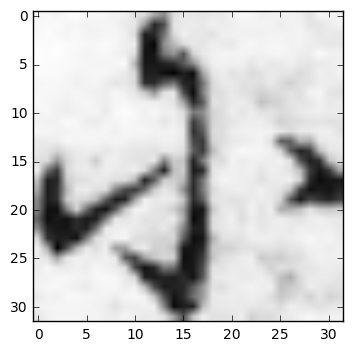

In [128]:
image = cv.imread("u306b_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [129]:
model.predict(x)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

### ケース5 OK

1/1 [==============================] - 0s
ば


u'\u3070'

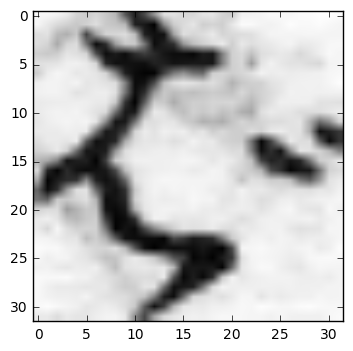

In [130]:
image = cv.imread("u3070_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [131]:
model.predict(x)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]], dtype=float32)

### ケース6 NG

1/1 [==============================] - 0s
に


u'\u306b'

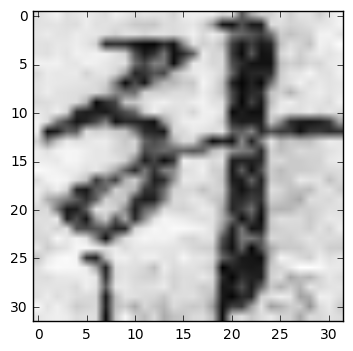

In [132]:
image = cv.imread("u5347_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [133]:
model.predict(x)

array([[ 0.   ,  0.   ,  0.   ,  0.874,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.003,  0.123]], dtype=float32)

### ケース7 OK

1/1 [==============================] - 0s
同


u'\u540c'

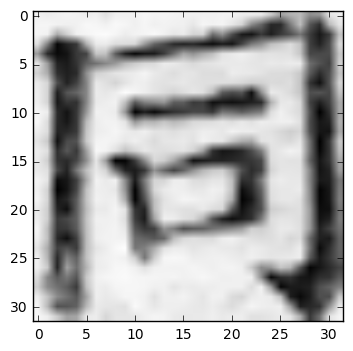

In [134]:
image = cv.imread("u540c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [135]:
model.predict(x)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

### ケース8 OK

1/1 [==============================] - 0s
色


u'\u8272'

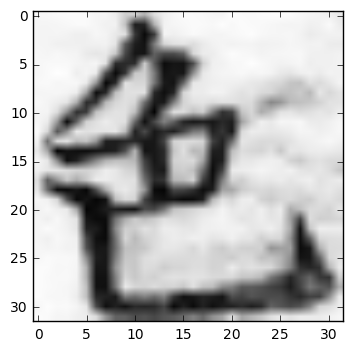

In [136]:
image = cv.imread("u8272_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [137]:
model.predict(x)

array([[ 0.   ,  0.589,  0.01 ,  0.4  ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]], dtype=float32)

### ケース9 OK

1/1 [==============================] - 0s
酒


u'\u9152'

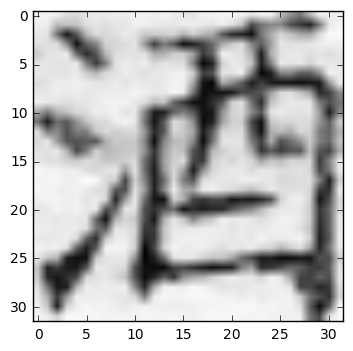

In [138]:
image = cv.imread("u9152_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [139]:
model.predict(x)

array([[ 0.   ,  0.   ,  0.   ,  0.122,  0.   ,  0.878,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]], dtype=float32)

### ケース10 NG

1/1 [==============================] - 0s
酒


u'\u9152'

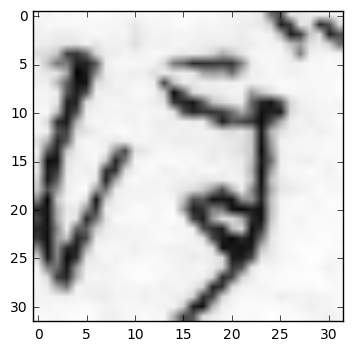

In [140]:
image = cv.imread("u307c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape)
labels_pred = model.predict_classes(x,verbose=1)
print(dic[labels_pred[0]])
dic[labels_pred[0]]

In [141]:
model.predict(x)

array([[ 0.   ,  0.   ,  0.   ,  0.027,  0.038,  0.935,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]], dtype=float32)